## Data Merge 

In [17]:
import polars as pl
import pandas as pd # Digunakan untuk konversi CSV ke XLSX
import os
import glob
import time

# --- Konfigurasi ---
VERBOSE_PER_FILE_LOGGING = False # Tidak menampilkan log detail per file
IGNORE_READ_ERRORS_IN_RAW_FILES = False 

def analyze_csv_header(file_path: str) -> tuple[list[str], bool]:
    """Menganalisis header CSV, mengembalikan (nama kolom, apakah kosong/error)."""
    try:
        header_df = pl.read_csv(file_path, n_rows=0, infer_schema_length=0)
        return (header_df.columns, False) if header_df.width > 0 else ([], True)
    except pl.exceptions.NoDataError: return [], True
    except Exception: return [], True

def prepare_df_for_excel_polars(df: pl.DataFrame) -> pl.DataFrame:
    """Modifikasi DataFrame Polars untuk Excel: URL di 'item_link' menjadi teks biasa."""
    if "item_link" in df.columns:
        df = df.with_columns(
            pl.when(pl.col("item_link").is_not_null() & (pl.col("item_link") != ""))
            .then(pl.lit("'") + pl.col("item_link"))
            .otherwise(pl.col("item_link"))
            .alias("item_link")
        )
    return df

def prepare_df_for_excel_pandas(df: pd.DataFrame) -> pd.DataFrame:
    """Modifikasi DataFrame Pandas untuk Excel: URL di 'item_link' menjadi teks biasa."""
    if "item_link" in df.columns:
        # Pastikan kolom adalah string sebelum konkatenasi
        df["item_link"] = df["item_link"].astype(str).apply(
            lambda x: f"'{x}" if x not in [None, "", "nan", "NaN", "<NA>"] else x
        )
    return df

def process_individual_categories_to_csv(base_raw_path: str, base_full_path: str, category_definitions: dict) -> tuple[list[str], list[dict]]:
    print("Starting category processing (Output: CSV only per category)...")
    output_csv_path = os.path.join(base_full_path, "CSV")
    os.makedirs(output_csv_path, exist_ok=True)
    print(f"Category CSVs will be saved in: {os.path.abspath(output_csv_path)}")

    generated_full_csv_files = []
    all_categories_summary = []
    total_rows_read_from_raw_files = 0 

    for category_name, rel_path in category_definitions.items():
        cat_folder = os.path.join(base_raw_path, rel_path)
        start_time = time.time()
        print(f"\nProcessing Category: {category_name}")
        csv_files = sorted(glob.glob(os.path.join(cat_folder, "*.csv")))

        if not csv_files:
            # ... (summary append)
            all_categories_summary.append({"Category": category_name, "Status": "No CSV files", "Files Found": 0, "Files Processed":0, "Rows Read Raw":0, "Total Rows Merged":0, "Time Taken (s)":0, "CSV Output": "N/A"})
            continue
        
        dataframes_cat = []
        processed_count = 0
        read_errors_cat = []
        rows_read_this_category = 0
        for fp in csv_files:
            fn = os.path.basename(fp)
            cols, empty = analyze_csv_header(fp)
            if empty or not cols:
                read_errors_cat.append(f"{fn} (Empty/No Header)")
                continue
            try:
                df = pl.read_csv(fp, schema_overrides={n: pl.Utf8 for n in cols}, 
                                 infer_schema_length=0, ignore_errors=IGNORE_READ_ERRORS_IN_RAW_FILES)
                rows_read_this_category += df.height
                dataframes_cat.append(df)
                processed_count += 1
            except Exception as e:
                read_errors_cat.append(f"{fn} ({type(e).__name__})")
        
        total_rows_read_from_raw_files += rows_read_this_category

        if not dataframes_cat:
             # ... (summary append)
            all_categories_summary.append({"Category": category_name, "Status": "No valid data", "Files Found": len(csv_files), 
                                           "Files Processed":processed_count, "Rows Read Raw":rows_read_this_category, "Total Rows Merged":0, "Read Errors": read_errors_cat,
                                           "Time Taken (s)":round(time.time()-start_time,2), "CSV Output": "N/A"})
            continue
        
        if processed_count < len(csv_files):
            print(f"  INFO: Successfully processed {processed_count}/{len(csv_files)} files in {category_name}.")

        full_df = pl.concat(dataframes_cat, how="diagonal_relaxed")
        full_df = full_df.with_columns(pl.lit(category_name).alias("product_category"))
        print(f"  Category '{category_name}' concatenated: Rows={full_df.height}, Cols={full_df.width} (from {rows_read_this_category} raw rows read)")

        sani_cat_name = category_name.replace(' ', '_').replace('/', '_')
        csv_out = os.path.join(output_csv_path, f"Full_{sani_cat_name}.csv")
        csv_stat = "N/A"
        try:
            full_df.write_csv(csv_out, null_value="NaN")
            csv_stat = os.path.basename(csv_out); generated_full_csv_files.append(csv_out)
            print(f"  Saved Full CSV: {csv_stat}")
        except Exception as e: 
            print(f"  ERROR saving Full CSV for {category_name}: {e}"); csv_stat = f"Failed: {e}"
        
        all_categories_summary.append({"Category": category_name, "Status": "Processed", "Files Found": len(csv_files), 
                                   "Files Processed":processed_count, "Rows Read Raw":rows_read_this_category, "Total Rows Merged":full_df.height, 
                                   "CSV Output": csv_stat, "Read Errors": read_errors_cat,
                                   "Time Taken (s)":round(time.time()-start_time,2)})
    
    print(f"\nTotal rows read by Polars from all raw category files (before master concat): {total_rows_read_from_raw_files}")
    return generated_full_csv_files, all_categories_summary

def create_master_csv_with_polars(category_csv_paths: list[str], output_master_folder: str) -> tuple[str | None, int]:
    """Gabung Full_Category.csv menjadi MasterDataSales.csv menggunakan Polars."""
    print("\n\n--- Creating MasterDataSales.csv with Polars ---")
    master_csv_rows_polars_intended = 0
    if not category_csv_paths:
        print("No category CSVs provided. Skipping master CSV creation."); return None, master_csv_rows_polars_intended

    print(f"Merging {len(category_csv_paths)} 'Full_Category.csv' files...")
    all_dfs_for_master = []
    for fp_cat_csv in category_csv_paths:
        # ... (kode baca Full_*.csv seperti sebelumnya) ...
        fn_cat_csv = os.path.basename(fp_cat_csv)
        cols, empty = analyze_csv_header(fp_cat_csv)
        if empty or not cols: continue
        try:
            df = pl.read_csv(fp_cat_csv, schema_overrides={n: pl.Utf8 for n in cols}, 
                             infer_schema_length=0, null_values=["NaN"])
            if df.height > 0: all_dfs_for_master.append(df)
        except Exception as e: print(f"ERROR reading '{fn_cat_csv}' for master: {e}. Skipping.")


    if not all_dfs_for_master:
        print("No dataframes to merge for master CSV. Skipping."); return None, master_csv_rows_polars_intended

    master_df_polars = pl.concat(all_dfs_for_master, how="diagonal_relaxed")
    master_csv_rows_polars_intended = master_df_polars.height
    print(f"  Master DataFrame (in-memory via Polars): Rows={master_csv_rows_polars_intended}, Cols={master_df_polars.width}")

    master_csv_path = os.path.join(output_master_folder, "MasterDataSales.csv")
    try:
        master_df_polars.write_csv(master_csv_path, null_value="NaN")
        print(f"  SUCCESS: Saved Master CSV: {os.path.basename(master_csv_path)} ({master_csv_rows_polars_intended} rows intended)")
        
        # Verifikasi jumlah baris di file CSV yang baru ditulis
        try:
            with open(master_csv_path, 'r', encoding='utf-8') as f_check:
                line_count_on_disk = sum(1 for line in f_check)
            actual_data_rows_on_disk = line_count_on_disk - 1 # Kurangi header
            print(f"  VERIFICATION: Actual lines in '{os.path.basename(master_csv_path)}' on disk: {line_count_on_disk} (Data rows: {actual_data_rows_on_disk})")
            if actual_data_rows_on_disk != master_csv_rows_polars_intended:
                 print(f"  WARNING: Row count mismatch between Polars in-memory ({master_csv_rows_polars_intended}) and CSV on disk ({actual_data_rows_on_disk})!")
                 # Ini akan menjadi titik krusial jika ada perbedaan
            master_csv_rows_polars_intended = actual_data_rows_on_disk # Gunakan hitungan dari disk sebagai acuan
        except Exception as e_verify:
            print(f"  VERIFICATION ERROR: Could not perform line count on '{os.path.basename(master_csv_path)}': {e_verify}")
            # Jika verifikasi gagal, kita tetap teruskan dengan path, tapi row count mungkin tidak akurat
            # master_csv_rows_polars_intended tetap dari memori Polars.

        return master_csv_path, master_csv_rows_polars_intended
    except Exception as e:
        print(f"  ERROR saving Master CSV with Polars: {e}")
        return None, 0


def convert_master_csv_to_xlsx_with_pandas(master_csv_path: str | None, output_master_folder: str) -> tuple[str | None, bool]:
    """Konversi MasterDataSales.csv ke MasterDataSales.xlsx menggunakan Pandas."""
    if not master_csv_path or not os.path.exists(master_csv_path):
        print("\n--- Master XLSX Skipped: Master CSV not available for conversion. ---")
        return None, False

    print(f"\n\n--- Converting Master CSV ('{os.path.basename(master_csv_path)}') to XLSX with Pandas ---")
    master_xlsx_path = os.path.join(output_master_folder, "MasterDataSales.xlsx")
    xlsx_master_written = False
    
    print(f"  (Reading Master CSV using Pandas - this is fast)")
    try:
        # Baca dengan Pandas, pastikan semua string dan "NaN" adalah null Pandas
        df_pandas = pd.read_csv(master_csv_path, dtype=str, keep_default_na=False, na_values=["NaN"])
        print(f"  (Master CSV read by Pandas: {df_pandas.shape[0]} rows, {df_pandas.shape[1]} cols. Preparing for Excel...)")
        
        df_pandas_for_excel = prepare_df_for_excel_pandas(df_pandas.copy()) # Gunakan fungsi Pandas
        
        print(f"  (Writing to Master XLSX with Pandas - this can take time for {df_pandas_for_excel.shape[0]} rows)...")
        start_xlsx_time = time.time()
        try:
            df_pandas_for_excel.to_excel(master_xlsx_path, index=False, engine='xlsxwriter')
            print(f"  SUCCESS: Saved Master XLSX (via Pandas): {os.path.basename(master_xlsx_path)}")
            xlsx_master_written = True
        except ImportError: # xlsxwriter mungkin tidak terinstal untuk Pandas
            print("  WARNING: 'xlsxwriter' not found for Pandas. Trying 'openpyxl' engine...")
            try:
                df_pandas_for_excel.to_excel(master_xlsx_path, index=False, engine='openpyxl')
                print(f"  SUCCESS: Saved Master XLSX (via Pandas with openpyxl): {os.path.basename(master_xlsx_path)}")
                xlsx_master_written = True
            except Exception as e_openpyxl:
                print(f"  ERROR: Failed to save Master XLSX with Pandas/openpyxl: {e_openpyxl}")
        except Exception as e_xlsxw:
             print(f"  ERROR: Failed to save Master XLSX with Pandas/xlsxwriter: {e_xlsxw}")
        
        xlsx_time = time.time() - start_xlsx_time
        if xlsx_master_written:
            print(f"  (XLSX writing took {xlsx_time:.2f}s)")

    except Exception as e:
        print(f"  ERROR during CSV to XLSX conversion with Pandas: {e}")

    return master_xlsx_path if xlsx_master_written else None, xlsx_master_written


def generate_master_summary_from_final_csv(master_csv_file_path: str | None, actual_rows_in_csv: int):
    # ... (Fungsi summary sama seperti sebelumnya, tapi gunakan actual_rows_in_csv jika > 0)
    if not master_csv_file_path or not os.path.exists(master_csv_file_path):
        print("\n--- Master Data Summary Skipped: Master CSV file not available. ---")
        return
    
    print(f"\n\n--- Summary based on FINAL Master CSV: '{os.path.basename(master_csv_file_path)}' ---")
    # (actual_rows_in_csv adalah jumlah baris data dari verifikasi line count, atau dari Polars jika verifikasi gagal)
    # Jika kita ingin summary dari apa yang Polars baca dari CSV itu:
    try:
        cols_summary, empty_summary = analyze_csv_header(master_csv_file_path)
        if empty_summary or not cols_summary:
            print(f"  Master CSV {os.path.basename(master_csv_file_path)} empty/unreadable for summary."); return

        df_master = pl.read_csv(master_csv_file_path, schema_overrides={n: pl.Utf8 for n in cols_summary}, 
                                infer_schema_length=0, null_values=["NaN"])
        
        # Gunakan df_master.height untuk summary karena ini yang akan divalidasi
        total_rows_for_summary = df_master.height 
        print(f"Total Rows (Polars read from Master CSV): {total_rows_for_summary}")
        print(f"Total Columns (Polars read from Master CSV): {df_master.width} (Names: {df_master.columns})")
        
        # (Sisa kode summary: missing values, duplicates - sama seperti sebelumnya, gunakan total_rows_for_summary)
        print("\nMissing Value Counts per Column (from Master CSV):")
        null_summary_list = []
        for cn in df_master.columns:
            nc = df_master.select(pl.col(cn).is_null().sum()).item()
            if nc > 0: 
                percentage = (nc / total_rows_for_summary) * 100 if total_rows_for_summary > 0 else 0
                null_summary_list.append(f"  - {cn}: {nc} missing ({percentage:.2f}%)")
        if null_summary_list: print("\n".join(null_summary_list))
        else: print("  No missing values found in any column.")
        
        rows_any_null = df_master.filter(pl.any_horizontal(pl.all().is_null())).height
        percentage_rows_null = (rows_any_null / total_rows_for_summary) * 100 if total_rows_for_summary > 0 else 0
        print(f"Number of rows (in Master CSV) with at least one missing value: {rows_any_null} ({percentage_rows_null:.2f}%)")
        
        duplicates = total_rows_for_summary - df_master.unique(maintain_order=True).height
        print(f"Number of duplicate rows in Master CSV (would be removed by '.unique()'): {duplicates}")

    except Exception as e:
        print(f"  ERROR generating summary from Master CSV: {e}")


def validate_final_master_files(master_csv_path: str | None, master_xlsx_path: str | None, xlsx_master_written: bool):
    # ... (Fungsi validasi sama seperti sebelumnya, membandingkan CSV dan XLSX yang dibaca kembali) ...
    if not master_csv_path or not os.path.exists(master_csv_path):
        print("\n--- Master File Validation Skipped: Master CSV file not available. ---")
        return
    
    print("\n\n--- FINAL Master Files Validation (CSV vs XLSX) ---")
    # ... (Sama seperti sebelumnya, baca CSV dengan Polars, baca XLSX dengan Polars, bandingkan)
    df_csv_val, df_xlsx_val = None, None
    csv_val_attrs = {"rows": -1, "cols": -1, "names": []}
    xlsx_val_attrs = {"rows": -1, "cols": -1, "names": []}

    print(f"Validating content of Master CSV: '{os.path.basename(master_csv_path)}'")
    try:
        cols_csv_val, empty_csv_val = analyze_csv_header(master_csv_path)
        if not empty_csv_val and cols_csv_val:
            df_csv_val = pl.read_csv(master_csv_path, schema_overrides={n: pl.Utf8 for n in cols_csv_val}, 
                                     infer_schema_length=0, null_values=["NaN"])
            csv_val_attrs["rows"], csv_val_attrs["cols"], csv_val_attrs["names"] = df_csv_val.height, df_csv_val.width, df_csv_val.columns
            print(f"  Master CSV (read for validation): Rows={csv_val_attrs['rows']}, Cols={csv_val_attrs['cols']}")
        else: print(f"  ERROR: Master CSV '{os.path.basename(master_csv_path)}' empty/unreadable.")
    except Exception as e: print(f"  ERROR reading Master CSV for validation: {e}")

    if xlsx_master_written and master_xlsx_path and os.path.exists(master_xlsx_path):
        print(f"\nValidating content of Master XLSX: '{os.path.basename(master_xlsx_path)}'")
        try:
            # Baca XLSX dengan Polars untuk validasi
            df_xlsx_val = pl.read_excel(source=master_xlsx_path, sheet_name="MasterDataSales")
            xlsx_val_attrs["rows"], xlsx_val_attrs["cols"], xlsx_val_attrs["names"] = df_xlsx_val.height, df_xlsx_val.width, df_xlsx_val.columns
            print(f"  Master XLSX (read for validation): Rows={xlsx_val_attrs['rows']}, Cols={xlsx_val_attrs['cols']}")
        except Exception as e: print(f"  ERROR reading Master XLSX for validation: {e}")
    else:
        print("\nMaster XLSX validation skipped (file not successfully written or path unavailable).")

    if csv_val_attrs["rows"] != -1 and xlsx_val_attrs["rows"] != -1 :
        print("\nComparing Read-Back CSV and XLSX:")
        if csv_val_attrs["rows"] == xlsx_val_attrs["rows"]: print(f"  SUCCESS: Row counts match ({csv_val_attrs['rows']}).")
        else: print(f"  ERROR: Row count Mismatch! CSV: {csv_val_attrs['rows']}, XLSX: {xlsx_val_attrs['rows']}")
        
        if csv_val_attrs["names"] == xlsx_val_attrs["names"]: print(f"  SUCCESS: Column names and order match.")
        else:
            print(f"  ERROR: Column Mismatch! ")
            print(f"    CSV cols  ({csv_val_attrs['cols']}): {csv_val_attrs['names']}")
            print(f"    XLSX cols ({xlsx_val_attrs['cols']}): {xlsx_val_attrs['names']}")
    elif csv_val_attrs["rows"] != -1:
        print("\nValidation: Only Master CSV was available/readable for checks. XLSX not validated against CSV.")


if __name__ == "__main__":
    overall_start_time = time.time()
    # ... (script_location, path definitions, category_definitions_map as before) ...
    try:
        script_location = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        print("INFO: '__file__' not defined, using CWD. Ensure script is in 'Notebooks/' dir.")
        script_location = os.getcwd()
    print(f"Script running from: {script_location}")

    raw_datasets_path = os.path.normpath(os.path.join(script_location, "..", "Datasets", "Raw_Datasets"))
    full_datasets_path = os.path.normpath(os.path.join(script_location, "..", "Datasets", "Full_Datasets"))

    category_definitions_map = {
        "Laptops": "laptops", "Mobiles": "mobiles",
        "AC": os.path.join("other_electronics", "ac"), "Fridge": os.path.join("other_electronics", "fridge"),
        "Smartwatch": os.path.join("other_electronics", "smartwatch"),
        "Washingmachine": os.path.join("other_electronics", "washingmachine"),
        "Waterpurifier": os.path.join("other_electronics", "waterpurifier"),
        "Earbuds": os.path.join("peripherals", "earbuds"), "HDD": os.path.join("peripherals", "hdd"),
        "Memory_Cards": os.path.join("peripherals", "memory_cards"), "Monitor": os.path.join("peripherals", "monitor"),
        "Pen_Drives": os.path.join("peripherals", "pen_drives"), "Power_Bank": os.path.join("peripherals", "power_bank"),
        "SSD": os.path.join("peripherals", "ssd"), "Wired_Headset": os.path.join("peripherals", "wired_headset"),
        "Tablet": "tablet", "TVs": "tvs",
    }
    
    if not os.path.isdir(raw_datasets_path):
        print(f"ERROR: Raw_Datasets path does not exist: {os.path.abspath(raw_datasets_path)}")
    else:
        # Tahap 1: Proses kategori, HANYA buat CSV per kategori
        generated_category_csvs_list, summary_categories_list = process_individual_categories_to_csv(
            raw_datasets_path, full_datasets_path, category_definitions_map
        )

        print("\n\n--- Category CSV Processing Summary ---")
        # ... (Summary category seperti sebelumnya)
        if summary_categories_list:
            try:
                summary_df_categories = pl.DataFrame(summary_categories_list)
                print(summary_df_categories)
                categories_summary_csv_path = os.path.join(full_datasets_path, "category_processing_summary.csv")
                summary_df_categories.write_csv(categories_summary_csv_path)
                print(f"Category summary saved to: {os.path.basename(categories_summary_csv_path)}")
            except Exception as e:
                print(f"Error creating/saving category summary DataFrame: {e}\nRaw summary data: {summary_categories_list}")
        else:
            print("No category summary data to process.")


        # Tahap 2: Buat MasterDataSales.csv DENGAN POLARS
        master_csv_final_path, final_master_csv_row_count_from_polars = None, 0
        if generated_category_csvs_list:
             master_csv_final_path, final_master_csv_row_count_from_polars = create_master_csv_with_polars(
                 generated_category_csvs_list, full_datasets_path
             )
        else:
            print("\nMaster CSV creation skipped: No category CSVs were generated.")
        
        # Tahap 3: Konversi MasterDataSales.csv ke .xlsx DENGAN PANDAS
        master_xlsx_final_path, xlsx_master_file_written = None, False
        if master_csv_final_path:
            master_xlsx_final_path, xlsx_master_file_written = convert_master_csv_to_xlsx_with_pandas(
                master_csv_final_path, full_datasets_path
            )

        # Tahap 4: Hasilkan ringkasan dari MasterDataSales.csv (menggunakan jumlah baris dari Polars sebagai referensi)
        generate_master_summary_from_final_csv(master_csv_final_path, final_master_csv_row_count_from_polars)
        
        # Tahap 5: Validasi MasterDataSales.csv vs MasterDataSales.xlsx
        validate_final_master_files(master_csv_final_path, master_xlsx_final_path, xlsx_master_file_written)

    total_time = time.time() - overall_start_time
    print(f"\nDataset processing finished in {total_time:.2f} seconds.")
    print("Reminder: For Excel writing, 'xlsxwriter' (for Polars/Pandas) or 'openpyxl' (for Pandas) is needed.")
    print("          Excel writing is much slower than CSV. URLs in Excel are now plain text.")
    if IGNORE_READ_ERRORS_IN_RAW_FILES:
        print("WARNING: IGNORE_READ_ERRORS_IN_RAW_FILES was True. Row counts might be higher but data integrity for problematic rows is not guaranteed.")

INFO: '__file__' not defined, using CWD. Ensure script is in 'Notebooks/' dir.
Script running from: x:\Coding Project Files\Uni_Assignment\Big_Data\UAS\Weka_SalesData\Notebooks
Starting category processing (Output: CSV only per category)...
Category CSVs will be saved in: x:\Coding Project Files\Uni_Assignment\Big_Data\UAS\Weka_SalesData\Datasets\Full_Datasets\CSV

Processing Category: Laptops
  Category 'Laptops' concatenated: Rows=16848, Cols=12 (from 16848 raw rows read)
  Saved Full CSV: Full_Laptops.csv

Processing Category: Mobiles
  Category 'Mobiles' concatenated: Rows=17760, Cols=12 (from 17760 raw rows read)
  Saved Full CSV: Full_Mobiles.csv

Processing Category: AC
  Category 'AC' concatenated: Rows=6385, Cols=12 (from 6385 raw rows read)
  Saved Full CSV: Full_AC.csv

Processing Category: Fridge
  Category 'Fridge' concatenated: Rows=7440, Cols=12 (from 7440 raw rows read)
  Saved Full CSV: Full_Fridge.csv

Processing Category: Smartwatch
  Category 'Smartwatch' concatenat

## Data Cleaning


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# -------------------- LOAD CSV WITH PANDAS (Original Data) --------------------
df_original = pd.read_csv(
    "../Datasets/Full_Datasets/MasterData/MasterDataSales.csv",
    encoding="utf-8",
    on_bad_lines="skip",
    low_memory=False
)

# -------------------- LOAD CSV WITH PANDAS --------------------
df = pd.read_csv(
    "../Datasets/Full_Datasets/MasterData/MasterDataSales.csv",
    encoding="utf-8",
    on_bad_lines="skip",
    low_memory=False
)

# -------------------- PRINT INITIAL CHECKS --------------------
print("=== INITIAL DATAFRAME STATE ===")
print(f"Columns before cleaning: {list(df.columns)}")
print(f"Shape before cleaning: {df.shape}")
print("\nMissing values per column (before):")
print(df.isna().sum())
print(f"\nDuplicate row count (before): {df.duplicated().sum()}")

print("\nSample unique values in 'off_now' (before):")
print(df["off_now"].dropna().unique()[:20])

print("\nSample 'offer_price' and 'original_price' (first 5 rows before):")
print(df[["offer_price", "original_price"]].head(5))

=== INITIAL DATAFRAME STATE ===
Columns before cleaning: ['u_id', 'name', 'offer_price', 'original_price', 'off_now', 'total_ratings', 'total_reviews', 'rating', 'description', 'item_link', 'created_at', 'product_category']
Shape before cleaning: (177945, 12)

Missing values per column (before):
u_id                9360
name                   0
offer_price            0
original_price         0
off_now                0
total_ratings          0
total_reviews          0
rating                 0
description            0
item_link           9360
created_at             0
product_category       0
dtype: int64

Duplicate row count (before): 36

Sample unique values in 'off_now' (before):
['19% off' '32% off' '26% off' '24% off' '11% off' '27% off' '17% off'
 '39% off' '29% off' '34% off' '36% off' '42% off' '21% off' '33% off'
 '12% off' '28% off' '14% off' '48% off' '40% off' '20% off']

Sample 'offer_price' and 'original_price' (first 5 rows before):
   offer_price original_price
0        99

In [6]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# -------------------- LOAD & CLEAN --------------------
# Drop duplicate rows
df = df.drop_duplicates().reset_index(drop=True)

# Rename columns
df = df.rename(columns={
    "name": "product_name",
    "rating": "product_rating"
})

# Drop unnecessary columns
df = df.drop(columns=["u_id", "item_link", "created_at", "product_name", "product_category"], errors="ignore")

# Clean 'off_now'
df["off_now"] = (
    df["off_now"]
    .astype(str)
    .str.replace(r"%\s*off", "", regex=True)
    .str.replace(r"[^\d\.]", "", regex=True)
    .replace("", np.nan)
    .astype(float)
)

# Clean numeric price columns
for col in ["offer_price", "original_price"]:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(r"[^\d\.]", "", regex=True)
        .replace("", np.nan)
        .astype(float)
    )

# Convert product_rating to numeric first
df["product_rating"] = pd.to_numeric(df["product_rating"], errors="coerce")


# Check after cleaning
print("\n=== CLEANING DONE ===")
print("product_rating value counts:")
print(df["product_rating"].value_counts(dropna=False))
print("Missing values:\n", df.isna().sum())
print("────────────────────────────────────────────────────────")



=== CLEANING DONE ===
product_rating value counts:
product_rating
0.0    41299
4.3    21047
4.2    17064
4.4    16469
4.1    11182
4.0    10945
3.8     9262
4.5     8378
3.9     8075
3.7     5609
4.6     3959
4.7     3671
3.6     3170
3.5     2622
3.3     2597
3.4     2581
3.2     1834
5.0     1807
4.8     1571
3.0     1251
3.1     1122
2.8      475
2.9      327
2.7      311
4.9      267
2.3      249
2.6      175
2.5      166
2.0      109
2.4       95
1.0       83
1.7       43
2.2       34
1.8       17
1.6       15
1.3       15
2.1        7
1.5        4
1.9        2
Name: count, dtype: int64
Missing values:
 offer_price       0
original_price    0
off_now           0
total_ratings     0
total_reviews     0
product_rating    0
description       0
dtype: int64
────────────────────────────────────────────────────────


In [7]:

# -------------------- IMPUTATION --------------------
numeric_cols = ["offer_price", "original_price", "off_now", "total_ratings",  "product_rating", "total_reviews"]
categorical_cols = ["product_name", "description", "product_category"]

# Validation: keep only existing columns
numeric_cols = [col for col in numeric_cols if col in df.columns]
categorical_cols = [col for col in categorical_cols if col in df.columns]

# Remove fully NaN columns
numeric_cols = [col for col in numeric_cols if df[col].notna().sum() > 0]
categorical_cols = [col for col in categorical_cols if df[col].notna().sum() > 0]

# Numeric imputation using mean
if numeric_cols:
    num_imputer = SimpleImputer(strategy="mean")
    df[numeric_cols] = pd.DataFrame(
        num_imputer.fit_transform(df[numeric_cols]),
        columns=numeric_cols,
        index=df.index
    )

# Categorical imputation using most frequent
if categorical_cols:
    cat_imputer = SimpleImputer(strategy="most_frequent")
    df[categorical_cols] = pd.DataFrame(
        cat_imputer.fit_transform(df[categorical_cols]),
        columns=categorical_cols,
        index=df.index
    )

# -------------------- Final Check --------------------
print("\n=== AFTER FINAL IMPUTATION ===")
print("Missing values per column:")
print(df.isna().sum())



=== AFTER FINAL IMPUTATION ===
Missing values per column:
offer_price       0
original_price    0
off_now           0
total_ratings     0
total_reviews     0
product_rating    0
description       0
dtype: int64


In [9]:
df.head()

,offer_price,original_price,off_now,total_ratings,total_reviews,product_rating,description
0,99990.0,124283.0,19.0,0,0,0.0,"['AMD Ryzen 7 Octa Core Processor', '16 GB DDR..."
1,46990.0,69999.0,32.0,128,17,4.2,"['Intel Core i7 Processor (10th Gen)', '16 GB ..."
2,33990.0,45990.0,26.0,3600,370,4.3,"['Intel Core i3 Processor (10th Gen)', '8 GB D..."
3,43990.0,57990.0,24.0,2408,211,4.3,"['Intel Core i5 Processor (10th Gen)', '8 GB D..."
4,47990.0,70990.0,32.0,1209,100,4.4,"['Intel Core i5 Processor (10th Gen)', '8 GB D..."


In [11]:
# -------------------- CONVERT REMAINING COLUMNS --------------------
df["total_ratings"] = pd.to_numeric(df["total_ratings"], errors="coerce").astype("Int64")
df["total_reviews"] = pd.to_numeric(df["total_reviews"], errors="coerce").astype("Int64")
df["product_rating"] = pd.to_numeric(df["product_rating"], errors="coerce").astype("Float64")  # Use Float64 instead of Int64
df["description"] = df["description"].astype(str)

# -------------------- PRINT AFTER TYPE CONVERSIONS --------------------
print("\n=== AFTER TYPE CONVERSIONS ===")
print(f"Data types after conversions:\n{df.dtypes}")



=== AFTER TYPE CONVERSIONS ===
Data types after conversions:
offer_price       float64
original_price    float64
off_now           float64
total_ratings       Int64
total_reviews       Int64
product_rating    Float64
description        object
dtype: object


In [12]:
df.head()

,offer_price,original_price,off_now,total_ratings,total_reviews,product_rating,description
0,99990.0,124283.0,19.0,0,0,0.0,"['AMD Ryzen 7 Octa Core Processor', '16 GB DDR..."
1,46990.0,69999.0,32.0,128,17,4.2,"['Intel Core i7 Processor (10th Gen)', '16 GB ..."
2,33990.0,45990.0,26.0,3600,370,4.3,"['Intel Core i3 Processor (10th Gen)', '8 GB D..."
3,43990.0,57990.0,24.0,2408,211,4.3,"['Intel Core i5 Processor (10th Gen)', '8 GB D..."
4,47990.0,70990.0,32.0,1209,100,4.4,"['Intel Core i5 Processor (10th Gen)', '8 GB D..."


In [13]:
import pandas as pd
from sklearn.impute import SimpleImputer

# -------------------- DEFINE COLUMNS --------------------
numeric_cols = ["offer_price", "original_price", "off_now", "total_ratings",  "product_rating", "total_reviews"]
categorical_cols = ["product_name", "description", "product_category"]

# -------------------- VALIDATION --------------------
# Ensure the columns actually exist in the DataFrame
numeric_cols = [col for col in numeric_cols if col in df.columns]
categorical_cols = [col for col in categorical_cols if col in df.columns]

# Remove columns that are fully NaN (not suitable for imputation)
numeric_cols = [col for col in numeric_cols if df[col].notna().sum() > 0]
categorical_cols = [col for col in categorical_cols if df[col].notna().sum() > 0]

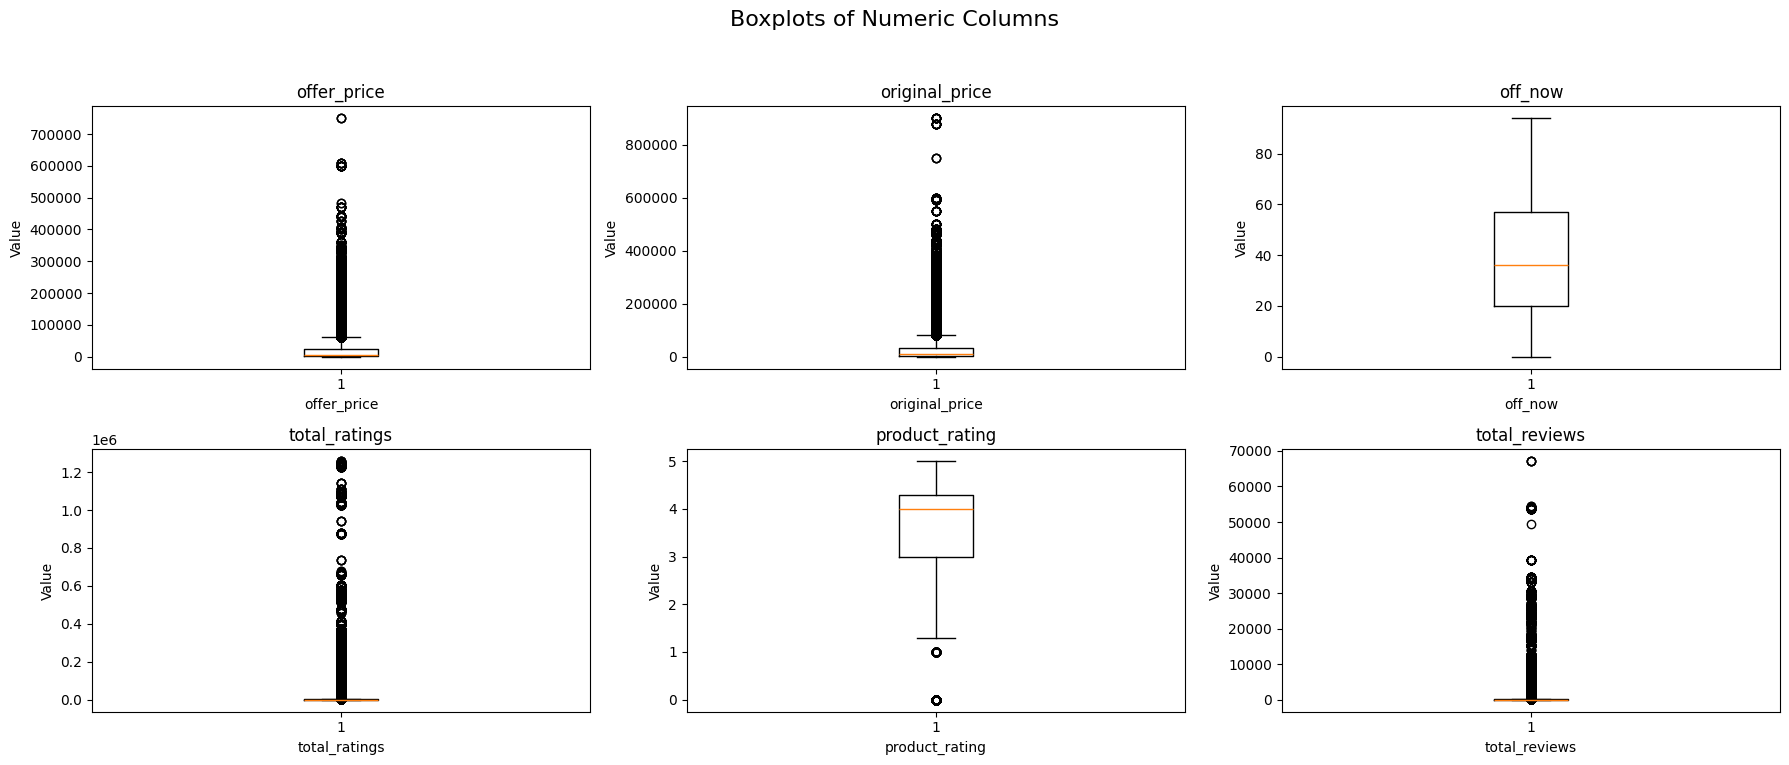

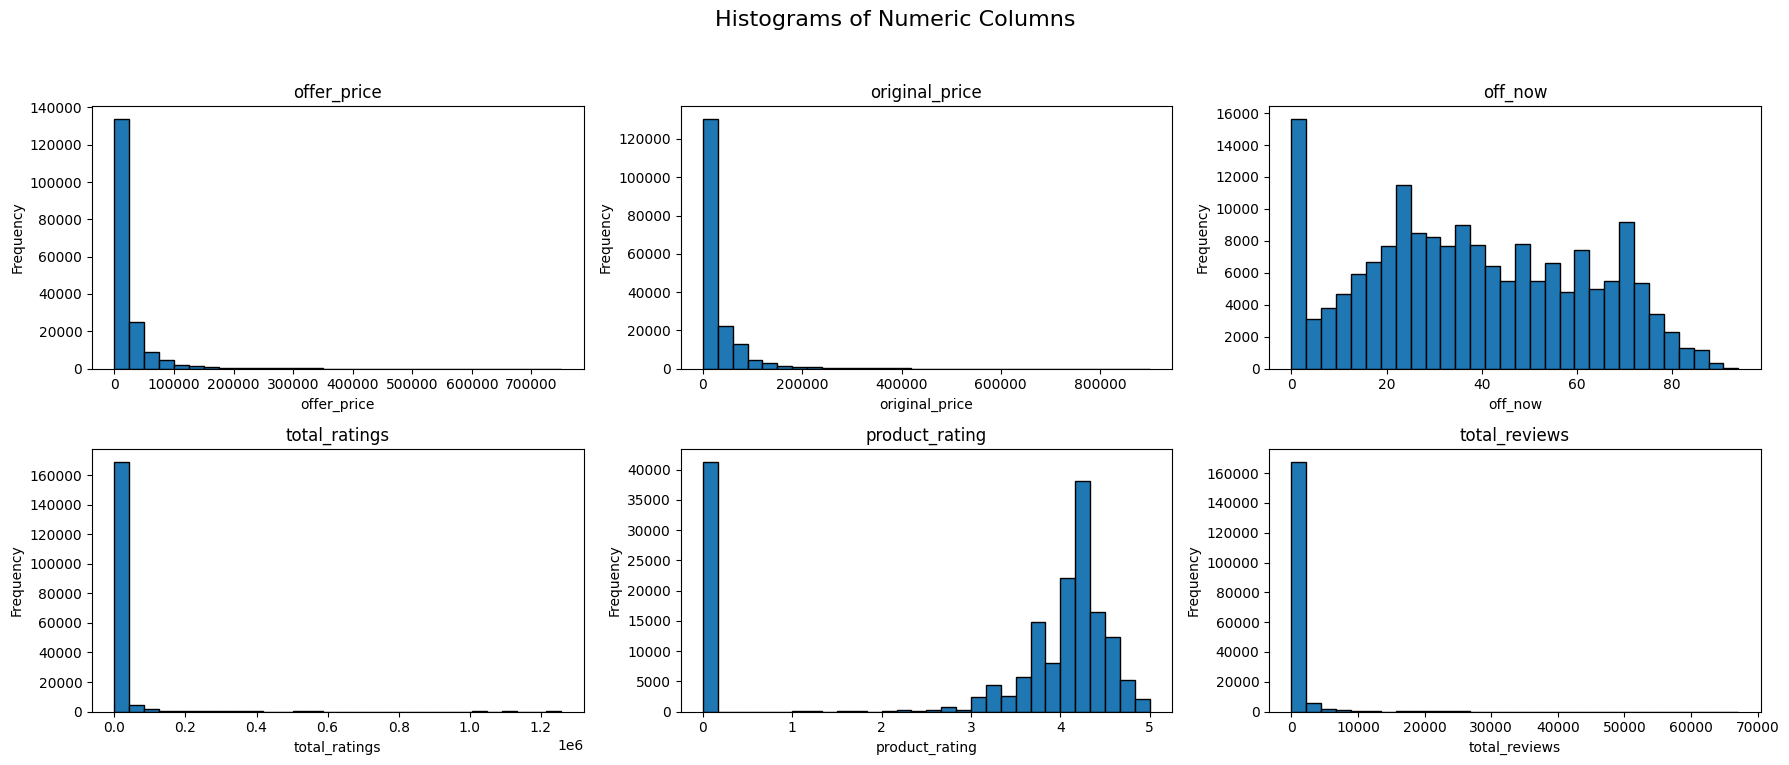


=== OUTLIER DETECTION SUMMARY (IQR METHOD) ===
  offer_price: lower=-34757.500, upper=60326.500, outliers=14819
  original_price: lower=-45987.500, upper=81976.500, outliers=14255
  off_now: lower=-35.500, upper=112.500, outliers=0
  total_ratings: lower=-3213.000, upper=5363.000, outliers=34097
  product_rating: lower=1.050, upper=6.250, outliers=41382
  total_reviews: lower=-111.000, upper=185.000, outliers=34244


In [14]:
# -------------------- OUTLIER DETECTION VISUALIZATIONS --------------------
n_cols = 3
n_rows = -(-len(numeric_cols) // n_cols)  # Ceiling division

# --- Boxplots: 1 row 3 columns layout ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
fig.suptitle("Boxplots of Numeric Columns", fontsize=16)
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    axes[idx].boxplot(df[col].dropna(), vert=True)
    axes[idx].set_title(f"{col}")
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Value")

# Hide unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Histograms: 1 row 3 columns layout ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
fig.suptitle("Histograms of Numeric Columns", fontsize=16)
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(df[col].dropna(), bins=30, edgecolor="black")
    axes[idx].set_title(f"{col}")
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Frequency")

# Hide unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Outlier Detection Summary (IQR Method) ---
print("\n=== OUTLIER DETECTION SUMMARY (IQR METHOD) ===")
for col in numeric_cols:
    series = df[col].dropna()
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    num_outliers = series[(series < lower) | (series > upper)].shape[0]
    print(f"  {col}: lower={lower:.3f}, upper={upper:.3f}, outliers={num_outliers}")

In [15]:
# -------------------- PRINT ORIGINAL DATASET SUMMARY --------------------
print("=== ORIGINAL DATAFRAME STATE ===")
print(f"Total rows (original): {df_original.shape[0]}")
print(f"Total columns (original): {df_original.shape[1]}")
print(f"\nMissing values per column (original):")
print(df_original.isna().sum())
print(f"\nDuplicate rows count (original): {df_original.duplicated().sum()}")

=== ORIGINAL DATAFRAME STATE ===
Total rows (original): 177945
Total columns (original): 12

Missing values per column (original):
u_id                9360
name                   0
offer_price            0
original_price         0
off_now                0
total_ratings          0
total_reviews          0
rating                 0
description            0
item_link           9360
created_at             0
product_category       0
dtype: int64

Duplicate rows count (original): 36


In [16]:
# -------------------- FINAL SUMMARY AFTER CLEANING --------------------
print("\n=== FINAL CLEANED DATAFRAME STATE ===")
print(f"Total rows (cleaned): {df.shape[0]}")
print(f"Total columns (cleaned): {df.shape[1]}")
print(f"\nMissing values per column (cleaned):")
print(df.isna().sum())
print(f"\nDuplicate rows count (cleaned): {df.duplicated().sum()}")
print("\nData types (cleaned):")
print(df.dtypes)


=== FINAL CLEANED DATAFRAME STATE ===
Total rows (cleaned): 177909
Total columns (cleaned): 7

Missing values per column (cleaned):
offer_price       0
original_price    0
off_now           0
total_ratings     0
total_reviews     0
product_rating    0
description       0
dtype: int64

Duplicate rows count (cleaned): 108480

Data types (cleaned):
offer_price       float64
original_price    float64
off_now           float64
total_ratings       Int64
total_reviews       Int64
product_rating    Float64
description        object
dtype: object


In [17]:
df.count()

offer_price       177909
original_price    177909
off_now           177909
total_ratings     177909
total_reviews     177909
product_rating    177909
description       177909
dtype: int64

In [ ]:
df.head

<bound method NDFrame.head of         offer_price  original_price  off_now  total_ratings  total_reviews  \
0           99990.0        124283.0     19.0              0              0   
1           46990.0         69999.0     32.0            128             17   
2           33990.0         45990.0     26.0           3600            370   
3           43990.0         57990.0     24.0           2408            211   
4           47990.0         70990.0     32.0           1209            100   
...             ...             ...      ...            ...            ...   
177904       5088.0         12999.0     60.0          11005           1581   
177905      14964.0         19990.0     25.0           2561            347   
177906      20825.0         32039.0     35.0              5              0   
177907      85700.0        145900.0     41.0             24              2   
177908       6599.0         15999.0     58.0            776            106   

        product_rating           

In [20]:
import os
file_name = "../Datasets/Full_Datasets/FinalDataCSV/FinalDataSalesNumeric.csv"
os.makedirs(os.path.dirname(file_name), exist_ok=True)
df.to_csv(file_name, index=False)

print(f"Data saved to {file_name}")

Data saved to ../Datasets/Full_Datasets/FinalDataCSV/FinalDataSalesNumeric.csv


## Data Saving 


In [21]:
import pandas as pd
import numpy as np
import os

# Load CSV dan bersihkan nama kolom
df = pd.read_csv("../Datasets/Full_Datasets/FinalDataCSV/FinalDataSalesNumeric.csv")
df.columns = [col.strip().replace(" ", "_").replace("-", "_") for col in df.columns]

# Ganti NaN dengan tanda ? (Weka-compatible)
df = df.replace({np.nan: "?"})

# Tentukan tipe atribut untuk ARFF
attributes = []
for col in df.columns:
    col_data = df[col]

    if col == "description":
        # Perlakukan 'description' sebagai STRING apa pun isinya
        attributes.append((col, "STRING"))
        continue

    if col_data.dtype == object or col_data.dtype.name == "category":
        unique_vals = col_data.dropna().unique()
        if 1 < len(unique_vals) <= 50:
            cleaned_vals = sorted(set(str(v).strip().replace("'", "").replace('"', "") for v in unique_vals))
            attributes.append((col, cleaned_vals))
        else:
            top_vals = col_data.value_counts().index[:50]
            cleaned_vals = sorted(set(str(v).strip().replace("'", "").replace('"', "") for v in top_vals))
            attributes.append((col, cleaned_vals))
            df[col] = df[col].apply(lambda x: x if x in top_vals else "?")
            print(f"⚠️ Column '{col}' has too many unique categories. Truncated to top 50 values.")
    else:
        attributes.append((col, "NUMERIC"))

# Escape value agar aman untuk ARFF
def escape_value(val):
    if val == "?":
        return val
    if isinstance(val, str):
        val = val.replace("\\", "\\\\").replace("'", "\\'").replace("\n", " ").replace("\r", " ").strip()
        return f"'{val}'"
    return val

# Konversi seluruh data menjadi baris untuk ARFF
data_rows = [[escape_value(cell) for cell in row] for row in df.values.tolist()]

# Bangun isi file ARFF
arff_lines = ["@RELATION FinalDataSales\n"]
for attr_name, attr_type in attributes:
    if isinstance(attr_type, list):
        enum_vals = ",".join(f"'{v}'" for v in attr_type)
        arff_lines.append(f"@ATTRIBUTE {attr_name} {{{enum_vals}}}")
    else:
        arff_lines.append(f"@ATTRIBUTE {attr_name} {attr_type}")
arff_lines.append("\n@DATA")
arff_lines.extend([",".join(map(str, row)) for row in data_rows])

# Simpan ke file .arff
output_path = "../Datasets/Full_Datasets/ARFF/FinalDataSalesNumeric.arff"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
with open(output_path, "w", encoding="utf-8") as f:
    f.write("\n".join(arff_lines))

print(f"\n✅ ARFF file saved: {output_path}")
print("📦 'description' stored as STRING. No truncation applied.")



✅ ARFF file saved: ../Datasets/Full_Datasets/ARFF/FinalDataSalesNumeric.arff
📦 'description' stored as STRING. No truncation applied.
